# Import necessary libs

In [1]:
import os
import random
import time
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn import functional as F
import torchvision

from PIL import Image
from sklearn.model_selection import train_test_split

# Prepare data

## Download data

In [2]:
!gdown 1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV

Downloading...
From (original): https://drive.google.com/uc?id=1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
From (redirected): https://drive.google.com/uc?id=1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV&confirm=t&uuid=62d713c6-1bdb-4c10-9975-df6d7105b89a
To: /content/icdar2003.zip
100% 45.7M/45.7M [00:00<00:00, 56.8MB/s]


In [3]:
!unzip icdar2003.zip

Archive:  icdar2003.zip
   creating: SceneTrialTrain/apanar_06.08.2002/
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1247.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1252.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1253.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1255.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1259.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1263.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1265.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1269.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1281.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1282.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1283.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1284.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1285.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1286.JPG 

## Extract from xml

In [4]:
def extract_data_from_xml(root_dir):
    xml_path = os.path.join(root_dir, 'words.xml')
    tree = ET.parse(xml_path)
    root = tree.getroot()

    img_paths = []
    img_sizes = []
    img_labels = []
    bboxes = []

    for img in root:
        bbs_of_img = []
        labels_of_img = []

        for bbs in img.findall('taggedRectangles'):
            for bb in bbs:
                # check non-alphabet and non-number
                if not bb[0].text.isalnum():
                  continue

                if "é" in bb[0].text.lower() or "ñ" in bb[0].text.lower():
                    continue

                bbs_of_img.append([
                    float(bb.attrib['x']),
                    float(bb.attrib['y']),
                    float(bb.attrib['width']),
                    float(bb.attrib['height'])
                ])
                labels_of_img.append(bb[0].text.lower())

        img_path = os.path.join(root_dir, img[0].text)
        img_paths.append(img_path)
        img_sizes.append((int(img[1].attrib["x"]), int(img[1].attrib["y"])))
        bboxes.append(bbs_of_img)
        img_labels.append(labels_of_img)

    return img_paths, img_sizes, img_labels, bboxes

In [5]:
dataset_dir = 'SceneTrialTrain'
img_paths, img_sizes, img_labels, bboxes = extract_data_from_xml(dataset_dir)

## Create dataset

We will create the dataset by combining each bounding box with its label

In [6]:
def split_bounding_boxes(img_paths, img_labels, bboxes, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    count = 0
    labels = []

    for img_path, img_label, bbox in zip(img_paths, img_labels, bboxes):
        img = Image.open(img_path)

        for label, bb in zip(img_label, bbox):
            # Crop image
            cropped_img = img.crop((bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]))
            # Filter out if 90% of the cropped image is black or white
            if np.mean(cropped_img) < 35 or np.mean(cropped_img) > 220:
                continue

            # Filter out if a size is too small
            if cropped_img.size[0] < 10 or cropped_img.size [1] < 10:
                continue
            # Save image
            file_name = f"{count:06d}.jpg"
            new_img_path = os.path.join(save_dir, file_name)
            cropped_img.save(new_img_path)

            label = new_img_path + '\t' + label
            labels.append(label)

            count += 1

    print(f"Created {count} images")

    # Write labels to a text file
    with open(os.path.join(save_dir, 'labels.txt'), 'w') as f:
        for label in labels:
            f.write(f'{label}\n')

In [7]:
save_dir = 'ocr_dataset'

split_bounding_boxes(img_paths, img_labels, bboxes, save_dir)

Created 1088 images


## Read data

In [8]:
root_dir = save_dir

img_paths = []
labels = []

with open(os.path.join(root_dir, 'labels.txt'), 'r') as f:
    for label in f:
        labels.append(label.strip().split('\t')[1])
        img_paths.append(label.strip().split('\t')[0])

print(f"Number of images: {len(img_paths)}")

Number of images: 1088


Print an image

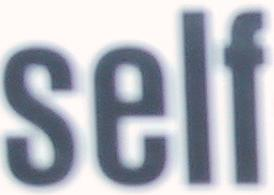

In [9]:
img = Image.open(img_paths[0])
img

## Create vocab

In [10]:
letters = [char.split(".")[0].lower() for char in labels]
letters = "".join(letters)
letters = sorted(list(set(list(letters))))

# create a string of all characters in the dataset
chars = "".join(letters)

blank_char = "-"
chars += blank_char
vocab_size = len(chars)

print(f"Vocab size: {vocab_size}")
print(f"Vocab: {chars}")

Vocab size: 37
Vocab: 0123456789abcdefghijklmnopqrstuvwxyz-


In [11]:
char_to_idx = {char: idx+1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

## Create string encoder and decoder

In [12]:
max_label_len = max([len(label) for label in labels])

def encode(label, char_to_idx, max_label_len):
    encoded_labels = torch.tensor(
        [char_to_idx[char] for char in label],
        dtype=torch.int32
    )
    label_len = len(encoded_labels)
    lengths = torch.tensor(label_len, dtype=torch.int32)
    padded_labels = F.pad(
        encoded_labels,
        (0, max_label_len - label_len),
        value=0
    )

    return encoded_labels, lengths

In [13]:
def decode(encoded_sequences, idx_to_char, blank_char='-'):
    decoded_sequences = []
    for seq in encoded_sequences:
        decoded_label = []
        prev_char = None

        for token in seq:
            if token != 0:
                char = idx_to_char[token.item()]
                if char != blank_char:
                    if char != prev_char or prev_char == blank_char:
                        decoded_label.append(char)
                prev_char = char
        decoded_sequences.append("".join(decoded_label))

    print(f"From {encoded_sequences} to {decoded_sequences}")
    return decoded_sequences

Testing

In [14]:
label = 'hello-world'
encoded_label, label_len = encode(label, char_to_idx, max_label_len)
decoded_label = decode([encoded_label], idx_to_char)

From [tensor([19, 16, 23, 23, 26,  1, 34, 26, 29, 23, 15,  0,  0,  0],
       dtype=torch.int32)] to ['heloworld']


## Create data transform

In [15]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.ColorJitter(
                brightness=0.5,
                contrast=0.5,
                saturation=0.5,
            ),
            transforms.Grayscale(
                num_output_channels=1,
            ),
            transforms.GaussianBlur(3),
            transforms.RandomAffine(
                degrees=1,
                shear=1,
            ),
            transforms.RandomPerspective(
                distortion_scale=0.3,
                p=0.5,
                interpolation=3,
            ),
            transforms.RandomRotation(degrees=2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
}

## Split data

In [16]:
seed = 0
val_size = 0.1
test_size = 0.1
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths,
    labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

## Create Pytorch dataset

In [17]:
class STRDataset(Dataset):
    def __init__(
        self,
        X,
        y,
        char_to_idx,
        max_label_len,
        label_encoder=None,
        transform=None,
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y
        self.char_to_idx = char_to_idx
        self.max_label_len = max_label_len
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        if self.label_encoder:
            encoded_label, label_len = self.label_encoder(
                label, self.char_to_idx, self.max_label_len
            )
        return img, encoded_label, label_len

## Create DataLoader

In [18]:
train_dataset = STRDataset(
    X_train,
    y_train,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["train"],
)
val_dataset = STRDataset(
    X_val,
    y_val,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["val"],
)
test_dataset = STRDataset(
    X_test,
    y_test,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["val"],
)

In [19]:
print(
    f"Train dataset: {len(train_dataset)}",
    f"Val dataset: {len(val_dataset)}",
    f"Test dataset: {len(test_dataset)}",
    sep="\n",
)

Train dataset: 881
Val dataset: 109
Test dataset: 98


In [20]:
train_batch_size = 64
test_batch_size = 64*2

train_dataloader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
)

# Modeling

## Main model

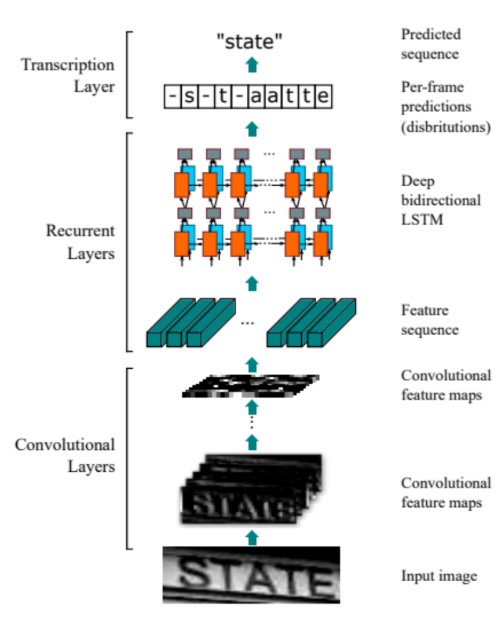

In [21]:
class CRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers,
                 dropout=0.2, unfreeze_layers=3):
        super(CRNN, self).__init__()
        backbone = timm.create_model("resnet152", in_chans=1, pretrained=True)
        modules = list(backbone.children())[:-2]
        modules.append(nn.AdaptiveAvgPool2d((1,None)))
        self.backbone = nn.Sequential(*modules)

        # Unfreeze the last few layers
        for param in self.backbone[-unfreeze_layers:].parameters():
            param.requires_grad = True

        self.mapSeq = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.gru = nn.GRU(
            512,
            hidden_size,
            n_layers,
            batch_first=True,
            bidirectional=True,
            dropout = dropout if n_layers > 1 else 0
        )
        self.layernorm = nn.LayerNorm(hidden_size * 2)

        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size),
            nn.LogSoftmax(dim=2)
        )

    @torch.autocast(device_type ="cuda")
    def forward(self, x):
        x = self.backbone(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1)
        x = self.mapSeq(x)
        x, _ = self.gru(x)
        x = self.layernorm(x)
        x = self.out(x)
        x = x.permute(1, 0, 2)
        return x

## training and evaluating functions

In [22]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for idx, (inputs, labels, labels_len) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            outputs = model(inputs)
            logits_lens = torch.full(
                size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long
            ).to(device)

            # Print some samples after decoding
            # if idx == 0:
            #     print(decode(outputs.permute(1, 0, 2).argmax(2), idx_to_char)[:10])
            #     print(decode(labels, idx_to_char)[:10])

            loss = criterion(outputs, labels, logits_lens, labels_len)
            losses.append(loss.item())

    loss = sum(losses) / len(losses)

    return loss

In [23]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs,
    max_grad_norm=2,
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        start = time.time()

        batch_train_losses = []

        model.train()
        for idx, (inputs, labels, labels_len) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long,
            ).to(device)

            loss = criterion(outputs, labels.cpu(), logits_lens.cpu(), labels_len.cpu())

            loss.backward()

            # Gradient clipping with a configurable max norm
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(
            f"EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\t\t Time: {time.time() - start:.2f} seconds"
        )

        scheduler.step()

    return train_losses, val_losses

## Create model

In [27]:
hidden_size = 256
n_layers = 3
dropout_prob = 0.2
unfreeze_layers = 3
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers,
).to(device)

In [28]:
epochs = 100
lr = 5e-4
weight_decay = 1e-5
scheduler_step_size = epochs * 0.5

criterion = nn.CTCLoss(
    blank=char_to_idx[blank_char],
    zero_infinity=True,
    reduction="mean",
)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=scheduler_step_size, gamma=0.1
)

## Train model

In [29]:
train_losses, val_losses = fit(
    model, train_dataloader, val_dataloader,
    criterion, optimizer, scheduler, device, epochs
)

EPOCH 1:	Train loss: 4.3953	Val loss: 3.5777		 Time: 15.19 seconds
EPOCH 2:	Train loss: 3.4378	Val loss: 3.4005		 Time: 14.15 seconds
EPOCH 3:	Train loss: 3.2812	Val loss: 3.2779		 Time: 14.23 seconds
EPOCH 4:	Train loss: 3.0900	Val loss: 3.1416		 Time: 15.57 seconds
EPOCH 5:	Train loss: 2.7216	Val loss: 3.0617		 Time: 14.18 seconds
EPOCH 6:	Train loss: 2.3861	Val loss: 2.6245		 Time: 14.10 seconds
EPOCH 7:	Train loss: 1.8825	Val loss: 2.0416		 Time: 14.22 seconds
EPOCH 8:	Train loss: 1.4647	Val loss: 1.5769		 Time: 14.34 seconds
EPOCH 9:	Train loss: 1.1138	Val loss: 1.5639		 Time: 14.48 seconds
EPOCH 10:	Train loss: 0.9060	Val loss: 1.1270		 Time: 14.47 seconds
EPOCH 11:	Train loss: 0.7404	Val loss: 0.9858		 Time: 14.24 seconds
EPOCH 12:	Train loss: 0.6057	Val loss: 1.1721		 Time: 14.11 seconds
EPOCH 13:	Train loss: 0.5291	Val loss: 0.8817		 Time: 14.28 seconds
EPOCH 14:	Train loss: 0.4219	Val loss: 1.0672		 Time: 14.25 seconds
EPOCH 15:	Train loss: 0.4443	Val loss: 0.8687		 Time: 14.

## Visualize

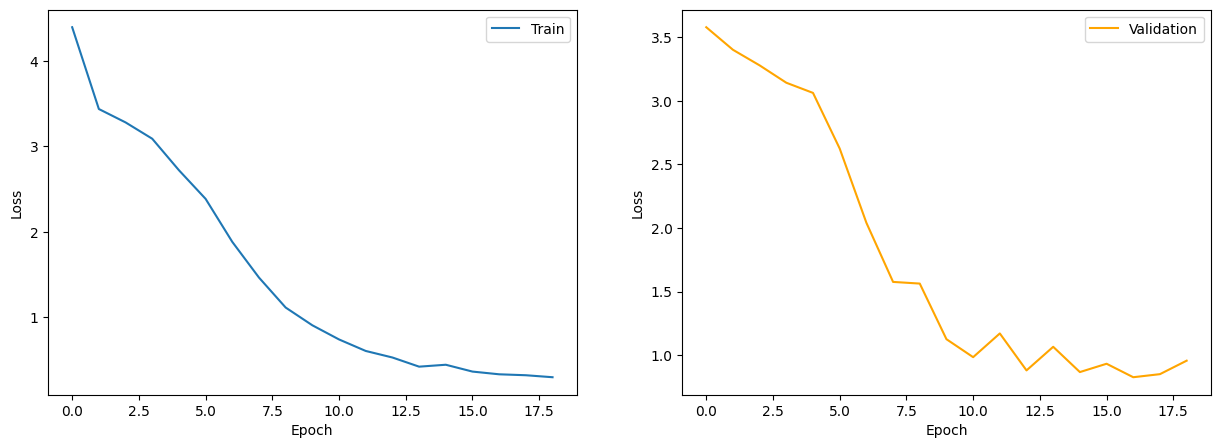

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_losses, label="Train")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(val_losses, label="Validation", color ='orange')
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend()

plt.show()

## Evaluate

In [36]:
val_loss = evaluate(model, val_dataloader, criterion, device)
test_loss = evaluate(model, test_dataloader, criterion, device)

print(f"Validation loss: {val_loss:.4f}")
print(f"Test loss: {test_loss:.4f}")

Validation loss: nan
Test loss: nan


## Save model

In [37]:
save_model_path = 'ocr_crnn.pt'
torch.save(model.state_dict(), save_model_path)

Download

In [38]:
from google.colab import files
files.download(save_model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>